# Anisotropic Filtering Neural Network

In [34]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

from concurrent.futures import ThreadPoolExecutor

import cv2 as cv

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from anisotropic import anisodiff

### Create the filtered images that will be used to train the neural network as the expected output.

In [2]:
def convert_to_grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [3]:
def apply_anisotropic_diffusion(image, 
                                niter=50, 
                                kappa=20, 
                                gamma=0.2, 
                                step=(1., 1.), 
                                option=1, 
                                ploton=False):
    return anisodiff(image, 
                     niter=niter, 
                     kappa=kappa, 
                     gamma=gamma, 
                     step=step, 
                     option=option, 
                     ploton=ploton)

In [4]:
original_images_path = "data/original/"
filtered_images_path = "data/filtered/"

In [5]:
if not os.path.exists(filtered_images_path):
    os.makedirs(filtered_images_path)

In [6]:
original_images = [image for image in os.listdir(original_images_path)]

In [7]:
for image in original_images:
    image_path = os.path.join(original_images_path, image)
    image_filtered_path = os.path.join(filtered_images_path, image)
    
    if os.path.exists(image_filtered_path):
        continue
    
    image = cv.imread(image_path)
    gray_image = convert_to_grayscale(image)
    image_filtered = apply_anisotropic_diffusion(gray_image)
    
    cv.imwrite(image_filtered_path, image_filtered)

### Create windows for the neural network to learn from.

In [8]:
window_size = 32

In [9]:
def load_image(filename):
    image_x = cv.imread(os.path.join(original_images_path, filename), 
                        cv.IMREAD_COLOR)
    image_x = convert_to_grayscale(image_x)
    image_y = cv.imread(os.path.join(filtered_images_path, filename), 
                        cv.IMREAD_GRAYSCALE)
    
    return image_x, image_y

In [10]:
with ThreadPoolExecutor(max_workers=10) as exe:
    images = list(exe.map(load_image, original_images))

In [11]:
def create_window_set():
    image = random.randrange(len(images))
    image_x, image_y = images[image]

    h, w = image_x.shape[:2]

    y = random.randrange(0, h - window_size)
    x = random.randrange(0, w - window_size)

    return (image_x[y:y+window_size, x:x+window_size].copy(),
            image_y[y:y+window_size, x:x+window_size].copy())

In [12]:
N = 250000

In [13]:
train_data = []

In [14]:
for i in range(N):
    image_x, image_y = create_window_set()
    
    train_data.append((image_x, image_y))

### Neural Network Architecture

In [15]:
def DownBlock(X, filters, dropout_rate=0., module_name=None):
    X = Conv2D(filters, (3, 3), activation='relu', padding='same', name=f'{module_name}_conv1')(X)
    X = Conv2D(filters, (3, 3), activation='relu', padding='same', name=f'{module_name}_conv2')(X)
    X = MaxPooling2D((2, 2), name=f'{module_name}_pool')(X)
    X = Dropout(dropout_rate, name=f'{module_name}_dropout')(X)
    return X

In [16]:
def UpBlock(X, Y, filters, dropout_rate=0., module_name=None):
    X = UpSampling2D((2, 2), interpolation='bilinear', name=f'{module_name}_upsample')(X)
    X = Concatenate(name=f'{module_name}_concat')([X, Y])
    X = Conv2D(filters, (3, 3), activation='relu', padding='same', name=f'{module_name}_conv1')(X)
    X = Conv2D(filters, (3, 3), activation='relu', padding='same', name=f'{module_name}_conv2')(X)
    X = Dropout(dropout_rate, name=f'{module_name}_dropout')(X)
    return X    

In [17]:
def Unet(input_shape, filters=16, dropout_rate=0.):  
    X0 = Input(shape=input_shape, name='input_layer')
    
    X1 = DownBlock(X0, filters, dropout_rate, module_name='down_block1')
    X2 = DownBlock(X1, filters * 2, dropout_rate, module_name='down_block2')
    X3 = DownBlock(X2, filters * 4, dropout_rate, module_name='down_block3')
    X4 = DownBlock(X3, filters * 8, dropout_rate, module_name='down_block4')

    Y3 = UpBlock(X4, X3, filters * 8, dropout_rate, module_name='up_block3')
    Y2 = UpBlock(Y3, X2, filters * 4, dropout_rate, module_name='up_block2')
    Y1 = UpBlock(Y2, X1, filters * 2, dropout_rate, module_name='up_block1')
    Y0 = UpBlock(Y1, X0, filters, dropout_rate, module_name='up_block0')
    
    Z = Conv2D(1, (1, 1), activation='relu', padding='same', name='output_layer')(Y0)
    model = Model(inputs=X0, outputs=Z, name='Unet')
    
    return model

In [18]:
model = Unet(input_shape=(window_size, window_size, 1), filters=16, dropout_rate=0.2)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 down_block1_conv1 (Conv2D)     (None, 32, 32, 16)   160         ['input_layer[0][0]']            
                                                                                                  
 down_block1_conv2 (Conv2D)     (None, 32, 32, 16)   2320        ['down_block1_conv1[0][0]']      
                                                                                                  
 down_block1_pool (MaxPooling2D  (None, 16, 16, 16)  0           ['down_block1_conv2[0][0]']      
 )                                                                                             

### Neural Network Training

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [21]:
X = np.stack([xy[0] for xy in train_data]).astype("float32")
Y = np.stack([xy[1] for xy in train_data]).astype("float32") 

In [22]:
X /= 255.0
Y /= 255.0

In [23]:
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)

In [24]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

In [25]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [ ]:
"""
history = model.fit(
    X, Y,
    batch_size=8,
    epochs=10,
    validation_split=0.20,
    callbacks=callbacks
)
"""

Epoch 1/10
25000/25000 [==============================] - 376s 15ms/step - loss: 0.0022 - mae: 0.0320 - val_loss: 5.8651e-04 - val_mae: 0.0149 - lr: 0.0010
Epoch 2/10
25000/25000 [==============================] - 367s 15ms/step - loss: 0.0020 - mae: 0.0302 - val_loss: 5.4091e-04 - val_mae: 0.0141 - lr: 0.0010
Epoch 3/10
25000/25000 [==============================] - 367s 15ms/step - loss: 0.0019 - mae: 0.0300 - val_loss: 5.4002e-04 - val_mae: 0.0144 - lr: 0.0010
Epoch 4/10
25000/25000 [==============================] - 355s 14ms/step - loss: 0.0019 - mae: 0.0299 - val_loss: 4.9491e-04 - val_mae: 0.0125 - lr: 0.0010
Epoch 5/10
25000/25000 [==============================] - 364s 15ms/step - loss: 0.0019 - mae: 0.0298 - val_loss: 5.0719e-04 - val_mae: 0.0133 - lr: 0.0010
Epoch 6/10
25000/25000 [==============================] - 354s 14ms/step - loss: 0.0019 - mae: 0.0298 - val_loss: 4.9815e-04 - val_mae: 0.0128 - lr: 0.0010
Epoch 7/10
25000/25000 [==============================] - 364s 1

In [ ]:
#model.save('models/anisotropic_diffusion_unet.h5')

In [ ]:
model = load_model('models/anisotropic_diffusion_unet.h5')

### Neural Network Inference

In [30]:
def apply_filter(img, stride, batch_size = 256):
    height, width = img.shape

    pad_h = (-(height - window_size) % stride) % stride
    pad_w = (-(width - window_size) % stride) % stride
    img_padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='reflect')
    h_p, w_p = img_padded.shape

    coords, patches = [], []
    for y in range(0, h_p - window_size + 1, stride):
        for x in range(0, w_p - window_size + 1, stride):
            patch = img_padded[y:y + window_size, x:x + window_size]
            patches.append(patch)
            coords.append((y, x))

    patches = np.asarray(patches, dtype=np.float32) / 255.0
    patches = patches[..., np.newaxis]

    preds = model.predict(patches, batch_size=batch_size, verbose=0)
    preds = preds[..., 0]
    
    acc_sum    = np.zeros((h_p, w_p), dtype=np.float32)
    acc_count  = np.zeros((h_p, w_p), dtype=np.uint16)

    for (y, x), patch_pred in zip(coords, preds):
        acc_sum[y:y + window_size, x:x + window_size]   += patch_pred
        acc_count[y:y + window_size, x:x + window_size] += 1

    img_out = acc_sum / np.maximum(acc_count, 1)
    img_out = img_out[:height, :width]                      
    img_out = np.clip(img_out * 255, 0, 255).astype(np.uint8)
    return img_out

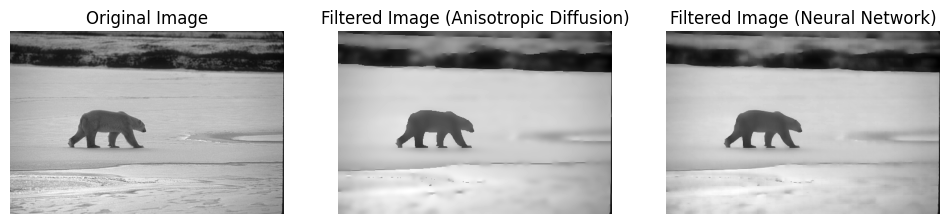

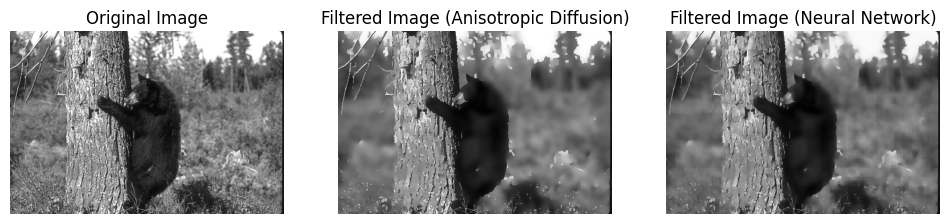

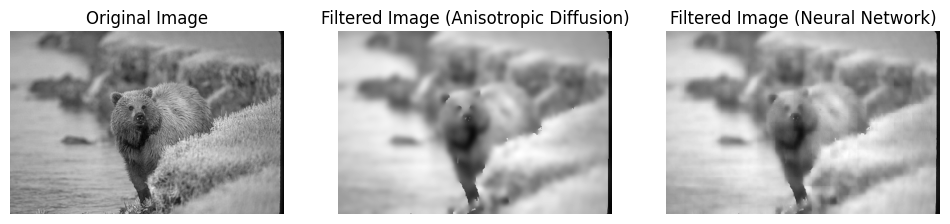

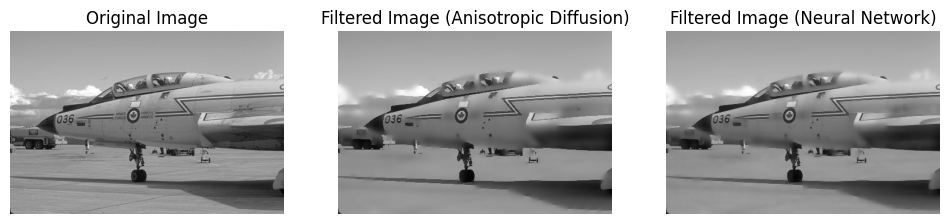

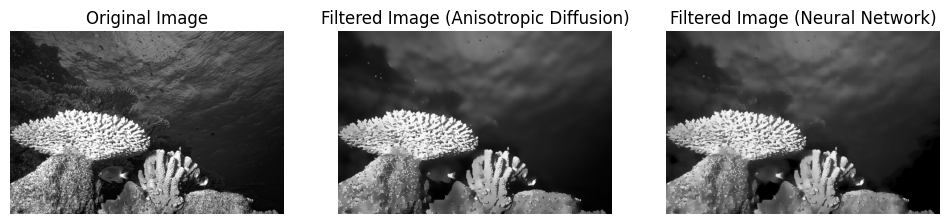

In [37]:
images = original_images[0:5]
for image in images:
    image_path = os.path.join(original_images_path, image)
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image_filtered_function = apply_anisotropic_diffusion(image, niter=50, kappa=20, gamma=0.2, step=(1., 1.), option=1, ploton=False)
    image_filtered_nn = apply_filter(image, stride=16, batch_size=256)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Filtered Image (Anisotropic Diffusion)')
    plt.imshow(image_filtered_function, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Filtered Image (Neural Network)')
    plt.imshow(image_filtered_nn, cmap='gray')
    plt.axis('off')
    plt.show()